In [ ]:
import io
import pandas as pd
from google.colab import files
!rm *.xlsx
uploaded = files.upload()

rm: cannot remove '*.xlsx': No such file or directory


Saving Cbasil_PHB_1G.xlsx to Cbasil_PHB_1G.xlsx
Saving Cbasil_PHB_LSMMG.xlsx to Cbasil_PHB_LSMMG.xlsx
Saving Ecoli_BC_1G.xlsx to Ecoli_BC_1G.xlsx
Saving Ecoli_BC_LSMMG.xlsx to Ecoli_BC_LSMMG.xlsx
Saving Ecoli_EYFP_1G.xlsx to Ecoli_EYFP_1G.xlsx
Saving Ecoli_EYFP_LSMMG.xlsx to Ecoli_EYFP_LSMMG.xlsx
Saving Ppas_BC_1G.xlsx to Ppas_BC_1G.xlsx
Saving Ppas_BC_LSMMG.xlsx to Ppas_BC_LSMMG.xlsx
Saving Ppas_BC_LUNAR.xlsx to Ppas_BC_LUNAR.xlsx
Saving Ppas_BC_MARTIAN.xlsx to Ppas_BC_MARTIAN.xlsx
Saving Ppas_Wild_1G.xlsx to Ppas_Wild_1G.xlsx
Saving Ppas_Wild_LSMMG.xlsx to Ppas_Wild_LSMMG.xlsx
Saving Ppas_Wild_LUNAR.xlsx to Ppas_Wild_LUNAR.xlsx
Saving Ppas_Wild_MARTIAN.xlsx to Ppas_Wild_MARTIAN.xlsx
Saving Pput_Wild_1G.xlsx to Pput_Wild_1G.xlsx
Saving Pput_Wild_LSMMG.xlsx to Pput_Wild_LSMMG.xlsx
Saving Scere_BC_1G.xlsx to Scere_BC_1G.xlsx
Saving Scere_BC_LSMMG.xlsx to Scere_BC_LSMMG.xlsx
Saving Scere_BC_LUNAR.xlsx to Scere_BC_LUNAR.xlsx
Saving Scere_BC_MARTIAN.xlsx to Scere_BC_MARTIAN.xlsx
Saving Sce

In [ ]:
import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
organism_list = []
substance_list = []
gravity_list = []
obj_list = []

class Preprocess:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_list, self.organism)
    self.update_list(substance_list, self.substance)
    self.update_list(gravity_list, self.gravity)

  def update_list(self, item_list, item):
    item_list.append(item)

In [ ]:
for file_name in uploaded.keys():
  obj = Preprocess(file_name)
  obj_list.append(obj)

In [ ]:
from sklearn.preprocessing import LabelEncoder

organism_encode = LabelEncoder()
substance_encode = LabelEncoder()
gravity_encode = LabelEncoder()

organism_label = organism_encode.fit_transform(organism_list)
substance_label = substance_encode.fit_transform(substance_list)
gravity_label = gravity_encode.fit_transform(gravity_list)

In [ ]:
import numpy as np

data_list = []

class Data:
  def __init__(self,file_name, organism, substance, gravity):
    self.file_name = file_name
    self.organism = organism
    self.substance = substance
    self.gravity = gravity
    self.titer_time, self.titer_val = self.assign_data()
    self.titer_input_np = []
    self.titer_val_np = []

    if len(self.titer_time) != 0:
      self.titer_input_np = self.create_inputs(self.titer_time, self.titer_val)
    if len(self.titer_val) != 0:
      self.titer_val_np = self.titer_val.reshape(-1, 1)

  def assign_data(self):
    titer_time = []
    titer_val = []

    if substance_encode.inverse_transform([self.substance])[0] != "Wild":
      titer_df = pd.read_excel(self.file_name, sheet_name = 1).iloc[1:]
      titer_time = titer_df.iloc[:,:1].to_numpy()
      titer_df_transpose = titer_df.iloc[:,1:].T
      titer_df_transpose.fillna(titer_df_transpose.mean(), inplace=True)
      titer_val = titer_df_transpose.T.to_numpy()

    return titer_time, titer_val

  def create_inputs(self, input, output):
    input_length = len(input)
    output_length = len(output[0])

    input_stacked = np.tile(input, output_length).reshape(-1, 1)

    categorical_inputs = [self.organism, self.substance, self.gravity]
    categorical_inputs_stacked = np.tile(categorical_inputs, input_length * output_length).reshape(-1, len(categorical_inputs))

    return np.hstack((categorical_inputs_stacked, input_stacked)).astype(float)

In [ ]:
for i, obj in enumerate(obj_list):
  data_obj = Data(obj.file_name, organism_label[i], substance_label[i], gravity_label[i])
  data_list.append(data_obj)

In [ ]:
#aggregate inputs and outputs
titer_input = data_list[0].titer_input_np
titer_output = data_list[0].titer_val_np

for i in range(1, len(data_list)):
  if len(data_list[i].titer_input_np) > 0:
    titer_input = np.vstack((titer_input, data_list[i].titer_input_np))
    titer_output = np.vstack((titer_output, data_list[i].titer_val_np))

In [ ]:
#standardize titer time
titer_time_input_mean = np.mean(titer_input[:, 3])
titer_time_input_std_dev = np.std(titer_input[:, 3])
titer_input[:,3] = (titer_input[:, 3] - titer_time_input_mean)/titer_time_input_std_dev
titer_output = np.log(titer_output + 0.1)

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

#80% train, 10% validation, 10% test
titer_input_train, titer_input_test_val, titer_output_train, titer_output_test_val = train_test_split(titer_input, titer_output, test_size = 0.2, random_state = 42)
titer_input_val, titer_input_test, titer_output_val, titer_output_test = train_test_split(titer_input_test_val, titer_output_test_val, test_size = 0.5, random_state = 42)

In [ ]:
titer_input_train_tensor = torch.tensor(titer_input_train, device=device)
titer_input_test_tensor = torch.tensor(titer_input_test,device=device)
titer_output_train_tensor = torch.tensor(titer_output_train,device=device)
titer_output_test_tensor = torch.tensor(titer_output_test,device=device)
titer_input_val_tensor = torch.tensor(titer_input_val, device=device)
titer_output_val_tensor = torch.tensor(titer_output_val, device=device)

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class Net_5(nn.Module):
    def __init__(self, nodes):
        super(Net_5,self).__init__()
        self.fc1 = nn.Linear(4, nodes)
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, 1)
        self.double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
import torch.optim as optim

learning_rate = 0.01
iter = 20000
nodes = 100
net = Net_5(nodes).to(device)

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for i in range(iter):
  # in your training loop:
  optimizer.zero_grad()   # zero the gradient buffers
  output = net(titer_input_train_tensor)
  loss = criterion(output, titer_output_train_tensor)
  loss.backward()
  optimizer.step()

In [ ]:
torch.save(net.state_dict(), 'HARV_titer_model_dec_4_five_layers_hundred_nodes_V1.pth')

files.download('HARV_titer_model_dec_4_five_layers_hundred_nodes_V1.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from torch import Tensor

In [ ]:
def prediction_2(categorical_inputs, min_time, max_time):
  time_linspace_tensor = torch.linspace(min_time, max_time, 1000, dtype = torch.double).reshape(-1,1)

  categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()
  categorical_inputs_transformed_stacked = Tensor.repeat(categorical_inputs_transformed, len(time_linspace_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_linspace_tensor))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - titer_time_input_mean) / titer_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output = net(input_standardized)
  predicted_output = torch.exp(predicted_output) - 0.1
  return time_linspace_tensor.numpy(), predicted_output.detach().numpy()

In [ ]:
def plot_growth(data_list):

  #generate predictions
  for data in data_list:
    data_list_time, data_list_output = prediction_2(
        [data.organism, data.substance, data.gravity],
        data.titer_time[0,0],
        data.titer_time[-1,0]
        )
    #plot predictions
    plt.plot(data_list_time, data_list_output, label=f"{gravity_encode.inverse_transform([data.gravity])[0]} Prediction")

    #stack the growth_time into one np array
    titer_time = np.empty(0)
    for i in range(len(data.titer_time)):
      temp = np.full(len(data.titer_val[0]), data.titer_time[i])
      titer_time = np.concatenate((titer_time, temp))
    #stack the growth_val into one np array
    titer_val = data.titer_val.reshape(-1, 1)
    #plot real data
    plt.scatter(titer_time, titer_val, label = f"{gravity_encode.inverse_transform([data.gravity])[0]}" if i == 0 else "")

  plt.title(f"{organism_encode.inverse_transform([data_list[0].organism])[0]} {substance_encode.inverse_transform([data_list[0].substance])[0]} Titer under Variable Gravity")
  plt.xlabel("Time (h)")
  plt.ylabel("Titer")
  plt.legend(fontsize = "8")
  plt.show()

In [ ]:
for i in range(len(data_list)):
  print(f"{i}: {data_list[i].file_name}")

0: Cbasil_PHB_1G.xlsx
1: Cbasil_PHB_LSMMG.xlsx
2: Ecoli_BC_1G.xlsx
3: Ecoli_BC_LSMMG.xlsx
4: Ecoli_EYFP_1G.xlsx
5: Ecoli_EYFP_LSMMG.xlsx
6: Ppas_BC_1G.xlsx
7: Ppas_BC_LSMMG.xlsx
8: Ppas_BC_LUNAR.xlsx
9: Ppas_BC_MARTIAN.xlsx
10: Ppas_Wild_1G.xlsx
11: Ppas_Wild_LSMMG.xlsx
12: Ppas_Wild_LUNAR.xlsx
13: Ppas_Wild_MARTIAN.xlsx
14: Pput_Wild_1G.xlsx
15: Pput_Wild_LSMMG.xlsx
16: Scere_BC_1G.xlsx
17: Scere_BC_LSMMG.xlsx
18: Scere_BC_LUNAR.xlsx
19: Scere_BC_MARTIAN.xlsx
20: Scere_Wild_1G.xlsx
21: Scere_Wild_LSMMG.xlsx
22: Scere_Wild_LUNAR.xlsx
23: Scere_Wild_MARTIAN.xlsx
24: Vnat_Wild_1G.xlsx
25: Vnat_Wild_LSMMG.xlsx
26: Ylipo_BC_1G.xlsx
27: Ylipo_BC_LSMMG.xlsx
28: Ylipo_BC_LUNAR.xlsx
29: Ylipo_BC_MARTIAN.xlsx
30: Ylipo_Wild_1G.xlsx
31: Ylipo_Wild_LSMMG.xlsx
32: Ylipo_Wild_LUNAR.xlsx
33: Ylipo_Wild_MARTIAN.xlsx


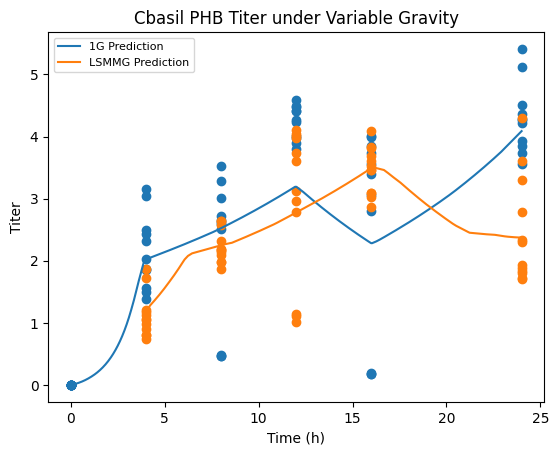

In [ ]:
#Cbasil PHB titer
plot_growth([data_list[0], data_list[1]])

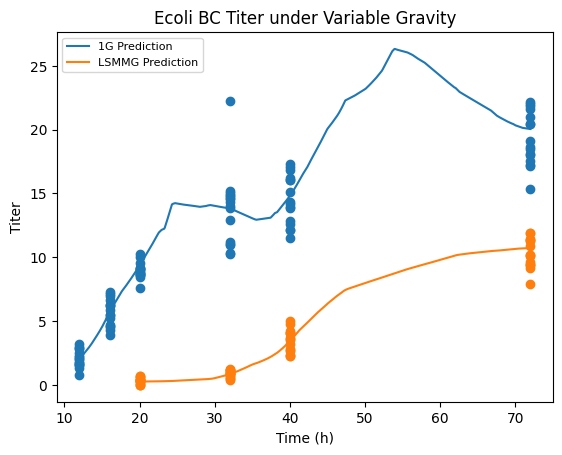

In [ ]:
#Ecoli BC titer
plot_growth([data_list[2], data_list[3]])

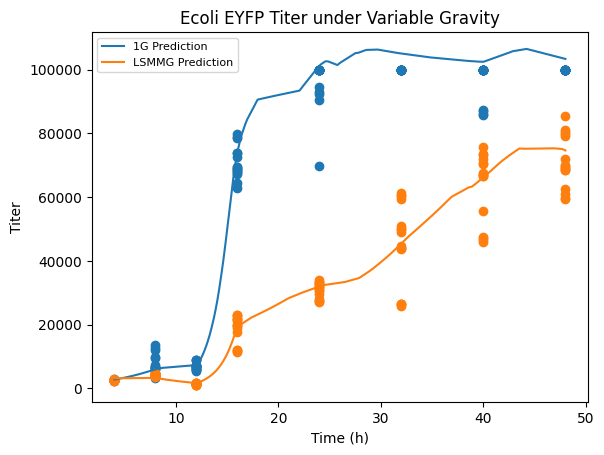

In [ ]:
#Ecoli EYFP titer
plot_growth([data_list[4], data_list[5]])

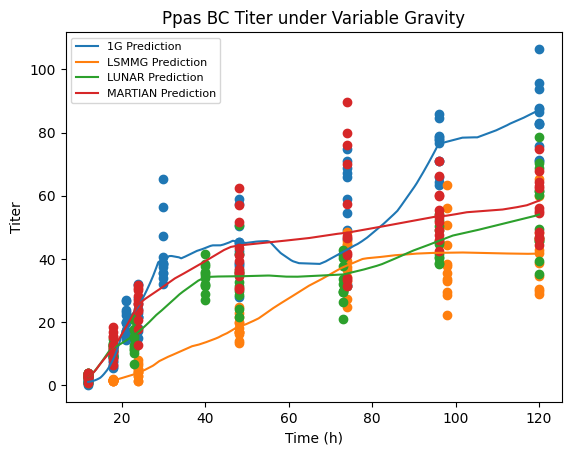

In [ ]:
#Ppas BC titer
plot_growth([data_list[6], data_list[7], data_list[8], data_list[9]])

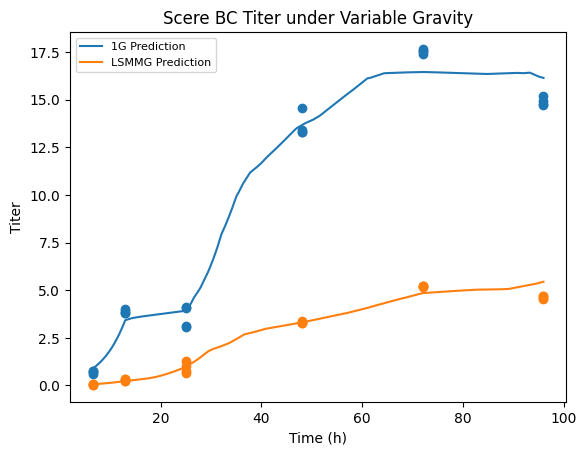

In [ ]:
#Scere BC titer
plot_growth([data_list[16], data_list[17]])

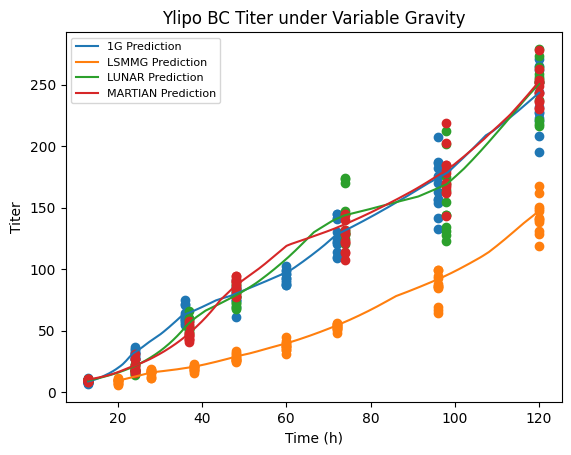

In [ ]:
#Ylipo BC titer
plot_growth([data_list[26], data_list[27], data_list[28], data_list[29]])